In [4]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
import time
import tensorflow as tf
# import xgboost as xgb

from sklearn import metrics
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from six.moves import range

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [5]:
# First, we'll download the dataset to our local machine. The data consists of characters
# rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J'
# (10 classes). The training set has about 500k and the testset 19000 labelled examples.
# Given these sizes, it should be possible to train models quickly on any machine.

In [6]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./notMNIST_large.tar.gz
Found and verified ./notMNIST_small.tar.gz


In [7]:
# Extract the dataset from the compressed .tar.gz file. This should give you a set of directories,
# labelled A through J.

In [8]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

./notMNIST_large already present - Skipping extraction of ./notMNIST_large.tar.gz.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
./notMNIST_small already present - Skipping extraction of ./notMNIST_small.tar.gz.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


In [9]:
# Problem 1: Display the images

In [10]:
display(Image(filename="notMNIST_small/A/Q0NXaWxkV29yZHMtQm9sZEl0YWxpYy50dGY=.png"))

In [11]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

./notMNIST_large/A.pickle already present - Skipping pickling.
./notMNIST_large/B.pickle already present - Skipping pickling.
./notMNIST_large/C.pickle already present - Skipping pickling.
./notMNIST_large/D.pickle already present - Skipping pickling.
./notMNIST_large/E.pickle already present - Skipping pickling.
./notMNIST_large/F.pickle already present - Skipping pickling.
./notMNIST_large/G.pickle already present - Skipping pickling.
./notMNIST_large/H.pickle already present - Skipping pickling.
./notMNIST_large/I.pickle already present - Skipping pickling.
./notMNIST_large/J.pickle already present - Skipping pickling.
./notMNIST_small/A.pickle already present - Skipping pickling.
./notMNIST_small/B.pickle already present - Skipping pickling.
./notMNIST_small/C.pickle already present - Skipping pickling.
./notMNIST_small/D.pickle already present - Skipping pickling.
./notMNIST_small/E.pickle already present - Skipping pickling.
./notMNIST_small/F.pickle already present - Skipping pi

In [12]:
# Problem 2

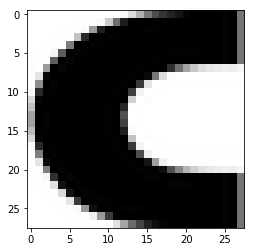

In [13]:
pickle_file = train_datasets[2]  # index 0 should be all As, 1 = all Bs, etc.
with open(pickle_file, 'rb') as f:
    letter_set = pickle.load(f)  # unpickle
    sample_idx = np.random.randint(len(letter_set))  # pick a random image index
    sample_image = letter_set[sample_idx, :, :]  # extract a 2D slice
    plt.figure()
    plt.imshow(sample_image, cmap = "Greys")  # display it

In [14]:
# Problem 3

In [15]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [16]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

In [17]:
# Problem 4

In [18]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [19]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800441


In [20]:
np.shape(train_dataset)
np.shape(train_labels)

(200000,)

In [17]:
# Play around and implement xgboost

In [86]:
model = LogisticRegression()

nsamples, nx, ny = train_dataset.shape
d2_train_dataset = train_dataset.reshape((nsamples,nx*ny))

nsamples, nx, ny = test_dataset.shape
d2_test_dataset = test_dataset.reshape((nsamples,nx*ny))

nsamples, nx, ny = valid_dataset.shape
d2_valid_dataset = valid_dataset.reshape((nsamples,nx*ny))

In [87]:
no_samples = 10000
train_sample = d2_train_dataset[0:no_samples,:]
label_sample = train_labels[0:no_samples]

In [88]:
start = time.time()
model.fit(train_sample, label_sample)
end = time.time()
end-start

56.885591983795166

In [89]:
fit.score(train_sample, label_sample)

0.78520000000000001

In [90]:
prediction_LR = model.predict(d2_valid_dataset)
print("logistic regression accuracy on validation set",
      metrics.accuracy_score(valid_labels, prediction_LR))

logistic regression accuracy on validation set 0.7889


In [92]:
dtrain = xgb.DMatrix(data = train_sample, label = label_sample)
dvalid = xgb.DMatrix(data = d2_valid_dataset)
dtest = xgb.DMatrix(d2_test_dataset)

# specify parameters via map
param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'multi:softmax', 'num_class':10}
num_round = 2
start = time.time()
bst = xgb.train(param, dtrain, num_round)
end = time.time()
end-start
# make prediction
preds = bst.predict(dvalid)

In [93]:
print("xgb accuracy on validation set", metrics.accuracy_score(valid_labels, preds))


xgb accuracy on validation set 0.6945


In [ ]:
# Assignment 2

In [21]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [22]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
train_subset = 10000

graph = tf.Graph()
with graph.as_default():

  # Input data.
  # Load the training, validation and test data into constants that are
  # attached to the graph.
  tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
  tf_train_labels = tf.constant(train_labels[:train_subset])
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  # These are the parameters that we are going to be training. The weight
  # matrix will be initialized using random values following a (truncated)
  # normal distribution. The biases get initialized to zero.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  # We multiply the inputs with the weight matrix, and add biases. We compute
  # the softmax and cross-entropy (it's one operation in TensorFlow, because
  # it's very common, and it can be optimized). We take the average of this
  # cross-entropy across all training examples: that's our loss.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
  # Optimizer.
  # We are going to find the minimum of this loss using gradient descent.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  # These are not part of training, but merely here so that we can report
  # accuracy figures as we train.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [23]:
num_steps = 801

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

with tf.Session(graph=graph) as session:
  # This is a one-time operation which ensures the parameters get initialized as
  # we described in the graph: random weights for the matrix, zeros for the
  # biases. 
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    # Run the computations. We tell .run() that we want to run the optimizer,
    # and get the loss value and the training predictions returned as numpy
    # arrays.
    _, l, predictions = session.run([optimizer, loss, train_prediction])
    if (step % 100 == 0):
      print('Loss at step %d: %f' % (step, l))
      print('Training accuracy: %.1f%%' % accuracy(
        predictions, train_labels[:train_subset, :]))
      # Calling .eval() on valid_prediction is basically like calling run(), but
      # just to get that one numpy array. Note that it recomputes all its graph
      # dependencies.
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Loss at step 0: 20.017239
Training accuracy: 9.1%
Validation accuracy: 11.1%
Loss at step 100: 2.282518
Training accuracy: 71.3%
Validation accuracy: 70.1%
Loss at step 200: 1.823540
Training accuracy: 74.5%
Validation accuracy: 73.0%
Loss at step 300: 1.578274
Training accuracy: 76.2%
Validation accuracy: 73.9%
Loss at step 400: 1.413955
Training accuracy: 77.2%
Validation accuracy: 74.2%
Loss at step 500: 1.293561
Training accuracy: 78.0%
Validation accuracy: 74.5%
Loss at step 600: 1.200259
Training accuracy: 78.5%
Validation accuracy: 74.7%
Loss at step 700: 1.125057
Training accuracy: 79.1%
Validation accuracy: 74.9%
Loss at step 800: 1.062576
Training accuracy: 79.7%
Validation accuracy: 75.0%
Test accuracy: 82.5%


In [24]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [27]:
num_steps = 6001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 16.330126
Minibatch accuracy: 16.4%
Validation accuracy: 18.4%
Minibatch loss at step 500: 1.082183
Minibatch accuracy: 81.2%
Validation accuracy: 75.6%
Minibatch loss at step 1000: 1.477970
Minibatch accuracy: 78.1%
Validation accuracy: 76.7%
Minibatch loss at step 1500: 0.762218
Minibatch accuracy: 81.2%
Validation accuracy: 77.1%
Minibatch loss at step 2000: 0.926550
Minibatch accuracy: 81.2%
Validation accuracy: 77.2%
Minibatch loss at step 2500: 0.947155
Minibatch accuracy: 75.0%
Validation accuracy: 77.7%
Minibatch loss at step 3000: 0.861619
Minibatch accuracy: 78.1%
Validation accuracy: 78.4%
Minibatch loss at step 3500: 0.734462
Minibatch accuracy: 79.7%
Validation accuracy: 78.6%
Minibatch loss at step 4000: 0.783343
Minibatch accuracy: 78.1%
Validation accuracy: 79.3%
Minibatch loss at step 4500: 0.862944
Minibatch accuracy: 79.7%
Validation accuracy: 79.3%
Minibatch loss at step 5000: 0.659028
Minibatch accuracy: 83.6%
Validation accura